### First steps
We create some functions to parse the data and declare some constants that would be useful

In [1]:
# Constants
max_length_name = 15

# function to convert a string to a list of ascii values
def transform_string(string):
   string = string.lower()
   ascii_list = [ord(c) for c in string]
   list_ = ascii_list + [0] * (max_length_name - len(ascii_list))
   return np.array(list_).astype(np.float32)


### Load libraries/API's

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


### Build Model

In [3]:
def build_model(vocab_size=128, embedding_dim=28, rnn_units=128):
    ''' Build a model with an embedding layer, bidirectional LSTM layer, and a dense layer.
        vocab_size: number of words in the vocabulary
        embedding_dim: dimension of the embedding vectors
        rnn_units: number of units in the RNN
    '''
    #build NN See. https://blog.paperspace.com/bidirectional-rnn-keras/
    #  https://towardsdatascience.com/boy-or-girl-a-machine-learning-web-app-to-detect-gender-from-name-16dc0331716c

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length_name))
    model.add(Bidirectional(LSTM(rnn_units, recurrent_dropout=0.2, dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))

    #Compile
    model.compile(loss='binary_crossentropy', optimizer=Adam(
        learning_rate=0.01), metrics=['accuracy'])

    return model


### Train the model

In [4]:
# load the data
df = pd.read_csv('unificado-clean.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape)
df.head(10)

(11741, 2)


,name,sex
0,sammie,1
1,bradford,1
2,clarine,0
3,elyse,0
4,devaughn,1
5,howard,0
6,irena,0
7,hector,1
8,suzette,0
9,janene,0


### Make the proportion equal 50/250

In [5]:
print("Males count: "+str(np.sum(df['sex']> 0)))
print("Females count: "+str(np.sum(df['sex'] < 1)))

df = df.drop(df[df['sex'] < 1].sample(2041).index)

print("Males count: "+str(np.sum(df['sex']> 0)))
print("Females count: "+str(np.sum(df['sex'] < 1)))

Males count: 4850
Females count: 6891
Males count: 4850
Females count: 4850


In [6]:
model = build_model()

In [7]:

X = np.asarray(df['name'].values.tolist())
Y = np.asarray(df['sex'].values.tolist())

#Tranform names to numbers
X = np.array([transform_string(val) for val in X])

In [8]:
history = model.fit(x=X, y=Y, batch_size=1024, epochs=100)
model.save('model_v1.h5')

Epoch 1/100
10/10 [==============================] - 21s 686ms/step - loss: 0.6877 - accuracy: 0.5385
Epoch 2/100
10/10 [==============================] - 7s 684ms/step - loss: 0.6352 - accuracy: 0.6445
Epoch 3/100
10/10 [==============================] - 7s 682ms/step - loss: 0.5673 - accuracy: 0.7140
Epoch 4/100
10/10 [==============================] - 7s 701ms/step - loss: 0.5495 - accuracy: 0.7273
Epoch 5/100
10/10 [==============================] - 7s 698ms/step - loss: 0.5401 - accuracy: 0.7320
Epoch 6/100
10/10 [==============================] - 7s 687ms/step - loss: 0.5217 - accuracy: 0.7459
Epoch 7/100
10/10 [==============================] - 7s 675ms/step - loss: 0.5102 - accuracy: 0.7558
Epoch 8/100
10/10 [==============================] - 7s 686ms/step - loss: 0.5022 - accuracy: 0.7586
Epoch 9/100
10/10 [==============================] - 7s 686ms/step - loss: 0.4912 - accuracy: 0.7638
Epoch 10/100
10/10 [==============================] - 7s 689ms/step - loss: 0.4822 - accur

In [9]:
#evaluate model
model.evaluate(X, Y)


304/304 [==============================] - 4s 11ms/step - loss: 0.1435 - accuracy: 0.9287


[0.14348705112934113, 0.9286597967147827]

In [10]:
def predict(name, model_loaded):
    data = np.array([transform_string(val) for val in name])
    result = model_loaded.predict(data)
    return ['m' if logit > 0.5 else 'f' for logit in result], [logit[0] for logit in result]


In [11]:
test_data = ['Roberto', 'Stephen', 'Allan', 'Amanda', 'beca']
predictions, logit = predict(test_data, model)
print(predictions)
print(logit)

['m', 'm', 'm', 'm', 'f']
[0.9933263, 0.9979049, 0.9899413, 0.690429, 0.08760598]


See the confusion matrix

<Figure size 1080x720 with 0 Axes>

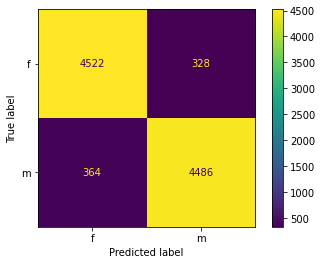

In [12]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


x = np.asarray(df['name'].values.tolist())
_, predicted = predict(x, model)
confusion_matrix = metrics.confusion_matrix(Y, np.rint(predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['f', 'm'])
plt.figure(figsize=(15, 10))
cm_display.plot()
plt.show()